# Analysis of traffic flow in California
![PeMS logo](images/ct_logo.png "PeMS logo")


Thanks to the website https://pems.dot.ca.gov/. We have acces to huge data of the traffic inside California's road. Caltrans Performance Measurement System (PeMS) provides avor 10 years of data historical analysis. Here, we are goig to use their sensors in order to predict traffic flow on the road.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import os

#Used to set the title to a bigger fixed size
sns.set(font_scale=5)


#columns names of our data according to the website PEMS

columns = ["timestamp", "station", "district", 
           "route", "direction", "lane_type",
           "station_lenght", "samples", "%_observed",
            "total_flow", "avg_occupancy", "avg_speed", "delay_35", "delay_40",
           "delay_45", "delay_50", "delay_55",
           "delay_60", "lane_n_flow", "lane_n_avg_occ",
           "lane_n_avg_speed"
          ]

In [2]:
def get_all_samples(directory: str, ending: str) -> list[str]:
    """
    Return the name of every file
    inside the specified directory
    and by specifying the type
    of file.
    
    :param directory: str
    :param ending: str
    :rparam files: list[str]
    """
    files = []
    for file in os.listdir(directory):
        if file.endswith("."+ending):
            files.append(os.path.join(directory, file))
    return files

## First analysis of our data

We have downloaded multiple files. Each of theses files has the same layout.
We will first analyze one data to see how we can first pre process our datas to analyze them.

In [3]:
example_file = "data/station_hour/d03_text_station_hour_2010_01.txt"
df_ex = pd.read_csv(example_file, header=None)
df_ex.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,01/01/2010 00:00:00,311831,3,5,S,OR,NaN,72,100,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/01/2010 00:00:00,311832,3,5,S,FR,NaN,72,100,252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/01/2010 00:00:00,311844,3,5,N,OR,NaN,238,100,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/2010 00:00:00,311845,3,5,N,FR,NaN,119,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/01/2010 00:00:00,311847,3,5,N,OR,NaN,210,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can first see two things. First, we don't have column's names in our files. Hopefully, the website provides the meaning of each columns. We will create a list containing each names and give them to our data. Second, we have few columns that are useless. Indeed their values is always NaN so we will get rid of them.

In [4]:

drop_col = list(range(len(columns), len(df_ex.columns)))
df_ex = df_ex.drop(columns=df_ex.iloc[:, drop_col])
df_ex.columns = columns
df_ex.head()

,timestamp,station,district,route,direction,lane_type,station_lenght,samples,%_observed,total_flow,...,avg_speed,delay_35,delay_40,delay_45,delay_50,delay_55,delay_60,lane_n_flow,lane_n_avg_occ,lane_n_avg_speed
0,01/01/2010 00:00:00,311831,3,5,S,OR,NaN,72,100,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN
1,01/01/2010 00:00:00,311832,3,5,S,FR,NaN,72,100,252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN
2,01/01/2010 00:00:00,311844,3,5,N,OR,NaN,238,100,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN
3,01/01/2010 00:00:00,311845,3,5,N,FR,NaN,119,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/01/2010 00:00:00,311847,3,5,N,OR,NaN,210,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will change the timestamp into something more readable and easier to analyse.

In [5]:
days = ["monday", "tuesday", "wednesday", 
        "thursday", "friday", "saturday", 
        "sunday"
       ]
df_ex.timestamp = pd.to_datetime(df_ex.timestamp)
df_ex["day"] = df_ex.timestamp.dt.day_name()
df_ex["hour"] = pd.DatetimeIndex(df_ex.timestamp).hour
df_ex["month"] = df_ex.timestamp.dt.month_name()
df_ex["year"] = pd.DatetimeIndex(df_ex.timestamp).year
df_ex = df_ex.drop(columns="timestamp")
df_ex.head()


,station,district,route,direction,lane_type,station_lenght,samples,%_observed,total_flow,avg_occupancy,...,delay_50,delay_55,delay_60,lane_n_flow,lane_n_avg_occ,lane_n_avg_speed,day,hour,month,year
0,311831,3,5,S,OR,NaN,72,100,28.0,NaN,...,NaN,NaN,NaN,28.0,NaN,NaN,Friday,0,January,2010
1,311832,3,5,S,FR,NaN,72,100,252.0,NaN,...,NaN,NaN,NaN,252.0,NaN,NaN,Friday,0,January,2010
2,311844,3,5,N,OR,NaN,238,100,246.0,NaN,...,NaN,NaN,NaN,17.0,NaN,NaN,Friday,0,January,2010
3,311845,3,5,N,FR,NaN,119,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Friday,0,January,2010
4,311847,3,5,N,OR,NaN,210,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Friday,0,January,2010


We can consider that our data is readable. We will now create a function to do this in each data.

In [6]:
def minimal_preprocessing_data(file_name: str) -> pd.DataFrame:
    """
    Add column's name to the DataFrame and 
    convert the time stamp to 4 columns 
    representing year, month, day and hour
    
    :param df: DataFrame
    :rparam df: DataFrame 
    """
    df = pd.read_csv(file_name, header=None)
    drop_col = list(range(len(columns), len(df.columns)))
    df = df.drop(columns=df.iloc[:, drop_col])
    df.columns = columns
    df.timestamp = pd.to_datetime(df.timestamp)
    df["day"] = df.timestamp.dt.day_name()
    df["hour"] = pd.DatetimeIndex(df.timestamp).hour
    df["month"] = df.timestamp.dt.month_name()
    df["year"] = pd.DatetimeIndex(df.timestamp).year
    #removed because it took too much times
    #this part was supposed to put year month day hour
    #in the front of the columns
#     df = df.loc[:, ["year", "month", "day","hour"] + columns] 
#     df = df.drop(columns="timestamp")
    return df
df_ex = minimal_preprocessing_data(example_file)
df_ex.head()

,timestamp,station,district,route,direction,lane_type,station_lenght,samples,%_observed,total_flow,...,delay_50,delay_55,delay_60,lane_n_flow,lane_n_avg_occ,lane_n_avg_speed,day,hour,month,year
0,2010-01-01,311831,3,5,S,OR,NaN,72,100,28.0,...,NaN,NaN,NaN,28.0,NaN,NaN,Friday,0,January,2010
1,2010-01-01,311832,3,5,S,FR,NaN,72,100,252.0,...,NaN,NaN,NaN,252.0,NaN,NaN,Friday,0,January,2010
2,2010-01-01,311844,3,5,N,OR,NaN,238,100,246.0,...,NaN,NaN,NaN,17.0,NaN,NaN,Friday,0,January,2010
3,2010-01-01,311845,3,5,N,FR,NaN,119,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Friday,0,January,2010
4,2010-01-01,311847,3,5,N,OR,NaN,210,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Friday,0,January,2010


In [7]:
df_ex.to_feather("test.feather")
df_ex = pd.read_feather("test.feather")

Note: 

After copmparing each type of save with https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
    
We will save our datas into feather file for optimization.

In [8]:
def create_new_datas(files: list[str], directory: str='') -> None:
    """
    Preprocessed each file of the list of files.
    The param directory allow the user to specify the directory
    where to put the output.
    
    :param files: str
    :param directory: str
    :rparam files: list[str]
    """
    for _, file in enumerate(tqdm(files)):
        df = minimal_preprocessing_data(file)
        df.to_feather(os.path.join(directory, file.replace('txt', 'feather').split('\\')[-1]))
    return None

In [9]:
files = get_all_samples("data/station_hour", "txt")
create_new_datas(files, "pre_data")

  0%|          | 0/151 [00:00<?, ?it/s]

## Analysis of our datas

We first create a function to get the column we want to analyze into a Dataframe because we don't have enaught memory to open our whole datas.

In [3]:
pre_files = get_all_samples("pre_data", "feather")

### Fastest get columns

We will create 3 functions and compare which one is the fastest.

In [4]:
def get_columns(files: list[str], columns: str) -> pd.DataFrame:
    """
    get from the list of files of feather type (note that it is possible to 
    modify it to use different type of file) the specified list of columns.
    
    :param files: str
    :param columns: str
    :rparam files: pd.DataFrame
    """
    col = pd.read_feather(pre_files[0])[columns]
    for _, file in enumerate(tqdm(pre_files[1:])):
        col = col.append(pd.read_feather(file)[columns])
    return col

def get_columns2(files: list[str], columns: str) -> pd.DataFrame:
    """
    get from the list of files of feather type (note that it is possible to 
    modify it to use different type of file) the specified list of columns.
    
    :param files: str
    :param columns: str
    :rparam files: pd.DataFrame
    """
    df_list = [pd.read_feather(file)[columns] \
    for file in pre_files]
    df = pd.concat(df_list)
    return df

def get_columns3(files: list[str], columns: str) -> pd.DataFrame:
    """
    get from the list of files of feather type (note that it is possible to 
    modify it to use different type of file) the specified list of columns.
    
    :param files: str
    :param columns: str
    :rparam files: pd.DataFrame
    """
    df_list = map(lambda file: pd.read_feather(file)[columns], files)
    df = pd.concat(df_list)
    return df

def get_columns_per_year(files: list[str], columns: str, year=2020) -> pd.DataFrame:
    """
    get from the list of files of feather type (note that it is possible to 
    modify it to use different type of file) the specified list of columns.
    
    :param files: str
    :param columns: str
    :rparam files: pd.DataFrame
    """
    filtered_files = [file for file in files if str(year) in file]
    df_list = [pd.read_feather(file)[columns] \
    for file in filtered_files]
    df = pd.concat(df_list)
    return df

In [12]:
%timeit -r 1 -n 1 get_columns(pre_files, ["day", "total_flow"])

  0%|          | 0/150 [00:00<?, ?it/s]

6min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%timeit -r 1 -n 1 get_columns2(pre_files, ["day", "total_flow"])

1min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%timeit -r 1 -n 1 get_columns3(pre_files, ["day", "total_flow"])

1min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We can see that the fastest way of doing it is with list comprehension. This seems logic because the append function is  O(n^2) in term of space complexity while concat is only O(n). Moreover, read_feather is a complex function which means that it performs better in list comprehension than in map function.

### Optimizing the data type

We want to optimize the size of our datasets because we have a lot of files. 

To do it, we will analyze our samples.
We clearly see that for every int64 we could reduce the size into an int16 and float64 into float16.

In [15]:
df = get_columns_per_year(pre_files, columns=columns+['day', 'hour', 'month'], year=2020)
for col in df.columns:
    print(f'{col}: {df[col].dtype, np.max(df[col])}')

timestamp: (dtype('<M8[ns]'), Timestamp('2020-12-31 23:00:00'))
station: (dtype('int64'), 3084081)
district: (dtype('int64'), 3)
route: (dtype('int64'), 267)
direction: (dtype('O'), 'W')
lane_type: (dtype('O'), 'OR')
station_lenght: (dtype('float64'), 5.0)
samples: (dtype('int64'), 844)
%_observed: (dtype('int64'), 100)
total_flow: (dtype('float64'), 14908.0)
avg_occupancy: (dtype('float64'), 0.9534)
avg_speed: (dtype('float64'), 91.0)
delay_35: (dtype('float64'), 1054.5)
delay_40: (dtype('float64'), 1084.4)
delay_45: (dtype('float64'), 1107.8)
delay_50: (dtype('float64'), 1127.1)
delay_55: (dtype('float64'), 1143.6)
delay_60: (dtype('float64'), 1157.5)
lane_n_flow: (dtype('float64'), 5136.0)
lane_n_avg_occ: (dtype('float64'), 1.0)
lane_n_avg_speed: (dtype('float64'), 97.5)
day: (dtype('O'), 'Wednesday')
hour: (dtype('int64'), 23)
month: (dtype('O'), 'September')


In [16]:
print("memory usage of the datset before: ", df.memory_usage(index=True).sum())

memory usage of the datset before:  2267841200


In order to change the dtype. Instead of doing it manualy, we will implement al algorithm that will loook after the maximum value and allocate the right number of bit according to this value.

In [17]:
for col in df.columns:
    dtype = str(df[col].dtypes)
    max_value = np.max(df[col]) # here, we take the max value
    aloc = 0
    if "int" in dtype: # we check the datatype
        if max_value < 127: # 8 bits
            aloc = 8
        elif max_value < 32_767: # 16 bits
            aloc = 16
        elif max_value < 2_147_483_647: # 32 bits
            aloc = 32
        df[col]= df[col].astype('int'+str(aloc))
    elif "float" in dtype:
        aloc = 16
        df[col] = df[col].astype('float'+str(aloc))

Note that we could reduce the value of station. Indeed, station is a categorical value. Therefore, it could be interesting to change each number to a value to 0 to the number of station. However, we need the station's number to correlate with other dataset. So we will keep these values. (we could use an other method but this is the easiest)

In [18]:
df.dtypes

timestamp           datetime64[ns]
station                      int32
district                      int8
route                        int16
direction                   object
lane_type                   object
station_lenght             float16
samples                      int16
%_observed                    int8
total_flow                 float16
avg_occupancy              float16
avg_speed                  float16
delay_35                   float16
delay_40                   float16
delay_45                   float16
delay_50                   float16
delay_55                   float16
delay_60                   float16
lane_n_flow                float16
lane_n_avg_occ             float16
lane_n_avg_speed           float16
day                         object
hour                          int8
month                       object
dtype: object

In [19]:
print("memory usage of the datset after: ", df.memory_usage(index=True).sum())

memory usage of the datset after:  963832510


We can see that we divided by 2 the memory usage of our dataset.

Now let's save into a json our dtype for each column. Then when we will load our dataset , we can put this json as the dtype of our dataframe. 

In [20]:
res = df.dtypes.to_frame('dtypes').reset_index()
d = res.set_index('index')['dtypes'].astype(str).to_dict()

In [21]:
import json
with open('types.json', 'w') as f:
    json.dump(d, f)

### Analysis of the traffic flow

Let's analyse the traffic per day

In [29]:
df = get_columns2(pre_files, ["day", "total_flow"])

In [30]:
print(f'{np.sum(df.total_flow.isna())/len(df.total_flow)*100:.2f}%')

10.06%


<AxesSubplot:xlabel='day'>

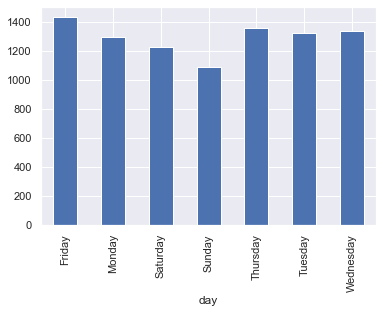

In [31]:
sns.set(font_scale=1)

df.groupby('day')['total_flow'].mean().plot.bar('total flow by days')

We can see that the traffic is less dense during the week end.

In [32]:
df = get_columns2(pre_files, ["hour", "total_flow"])

<AxesSubplot:title={'center':'total flow by hour of the day'}, xlabel='hour'>

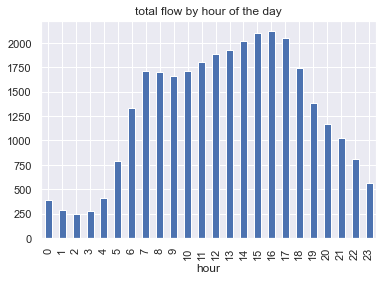

In [33]:
df.groupby('hour')['total_flow'].mean().plot.bar(title='total flow by hour of the day')

We clearly see the impact during the rush hour in the traffic.

In [12]:
df = get_columns2(pre_files, ["day", "hour", "total_flow"])

Let's create a heatmap of the traffic according to the hour and the day of the week.

In [13]:
df = df.groupby(['day', 'hour']).agg(['mean'])
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)
df

,day,hour,mean
0,Friday,0,372.571297
1,Friday,1,281.010159
2,Friday,2,251.495783
3,Friday,3,288.012256
4,Friday,4,453.428950
...,...,...,...
163,Wednesday,19,1343.125102
164,Wednesday,20,1124.668291
165,Wednesday,21,973.611549
166,Wednesday,22,729.682899


In [15]:
days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
            'Sunday')
heatmap_data = pd.pivot_table(df, values='mean', 
                              index=['day'], columns='hour').reindex(index = days)
heatmap_data

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,340.346408,250.161802,227.411654,281.736938,481.607855,937.887464,1569.205459,1988.562276,1867.517867,1681.640384,...,1988.875640,2126.586862,2179.044732,2095.728653,1675.407649,1262.428894,1036.369207,892.039423,671.683186,469.218031
Tuesday,327.129499,249.026730,227.624079,281.277572,476.330054,976.536437,1675.359655,2100.605902,1963.075535,1737.922695,...,1999.805895,2160.010808,2223.014273,2146.603884,1759.943647,1305.220777,1079.457972,933.022430,698.194820,482.788064
Wednesday,335.559721,255.246296,231.669430,279.377875,470.386965,963.716412,1659.999896,2091.649901,1962.682065,1750.524599,...,2023.764221,2170.445992,2232.865229,2158.718477,1796.246291,1343.125102,1124.668291,973.611549,729.682899,500.239843
Thursday,343.702211,259.772049,236.383893,282.741154,467.592917,947.822623,1636.870835,2070.124061,1948.577209,1743.555025,...,2053.075856,2194.509163,2233.961163,2159.835484,1834.672409,1406.945546,1187.422674,1042.092152,792.596677,545.390351
Friday,372.571297,281.010159,251.495783,288.012256,453.428950,895.215212,1546.965259,2006.661958,1906.500891,1765.278805,...,2200.241638,2279.722942,2280.549140,2207.653182,1946.971058,1583.609032,1325.467479,1214.900330,1015.744214,716.694731
Saturday,490.461652,361.735368,294.911817,261.590165,307.212036,454.473493,724.319333,1020.463770,1338.115658,1617.619166,...,1966.495564,1945.744327,1915.458195,1844.086760,1660.343099,1405.689090,1232.155978,1155.261213,1004.288326,731.939745
Sunday,502.266041,365.175597,290.209294,236.470800,248.938379,328.818548,489.290773,673.338739,949.121485,1316.384213,...,1891.578939,1844.163480,1792.314521,1716.170582,1542.754853,1355.623774,1191.060983,990.598283,741.866388,508.683732


Text(0.5, 1.0, ' California 2010-2022 Mean traffic flow')

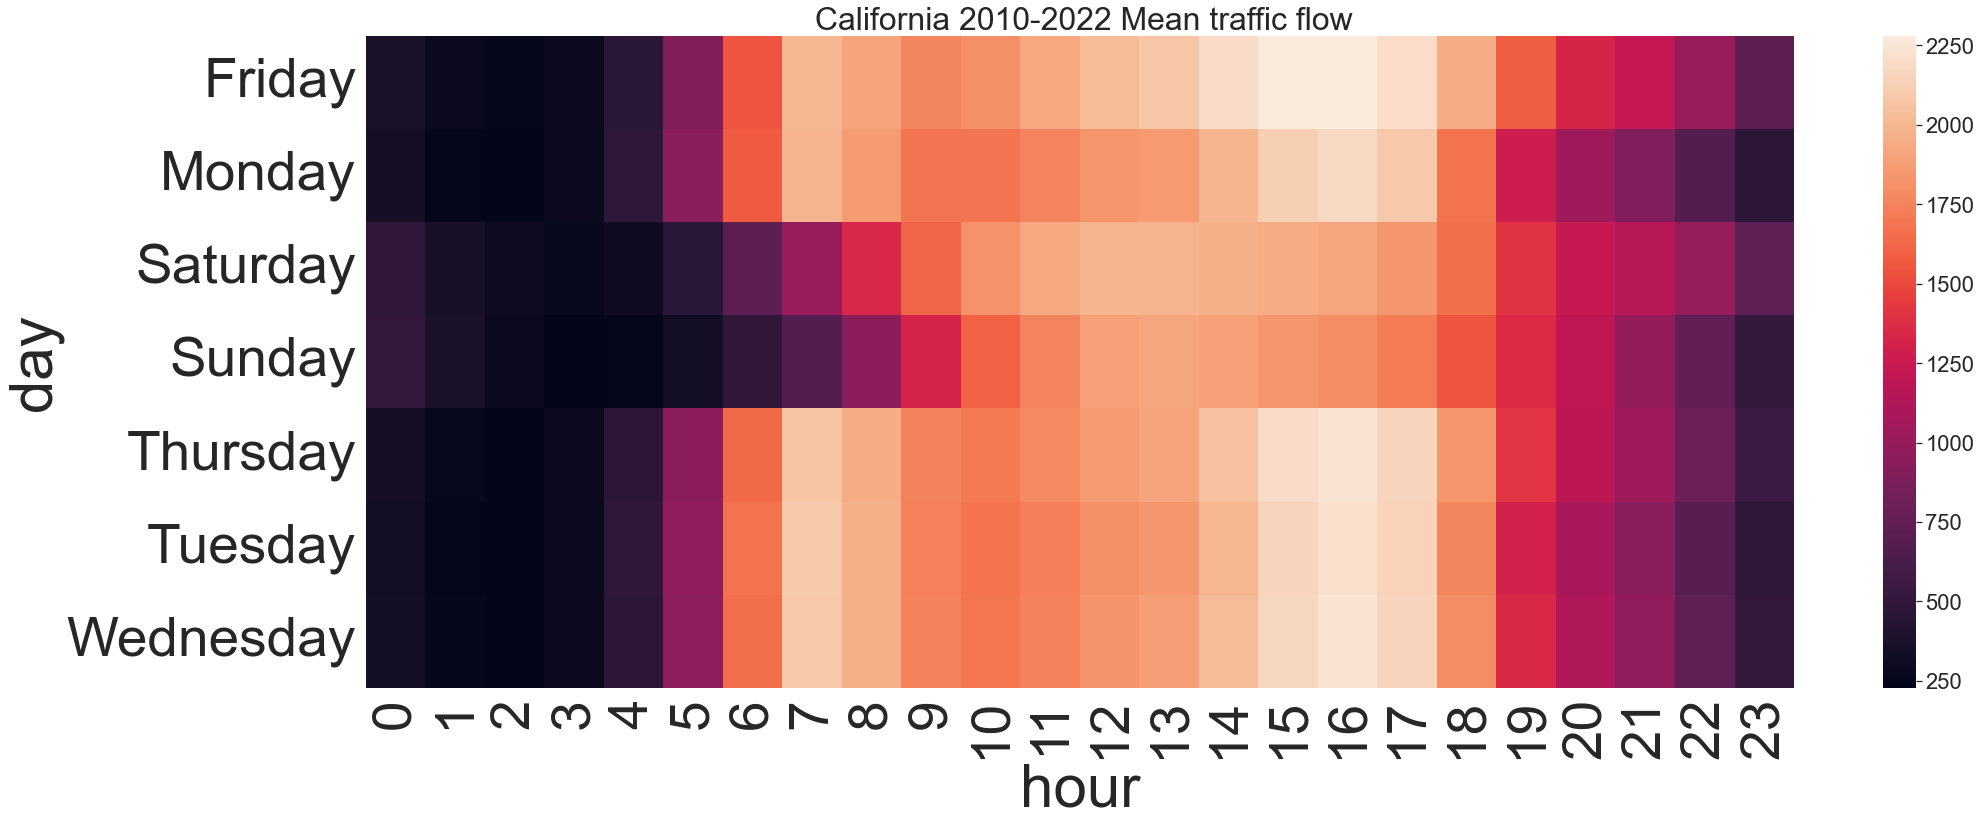

In [19]:

fig, ax = plt.subplots(figsize=(32,12))
sns.set(font_scale=2)

sns.heatmap(heatmap_data)
plt.title(" California 2010-2022 Mean traffic flow", size=32)

We can see that during the week end the traffic is equally distributed. While in the other days we clearly see the time of the rush hours.

Let's see if the seamap changes according to the year.

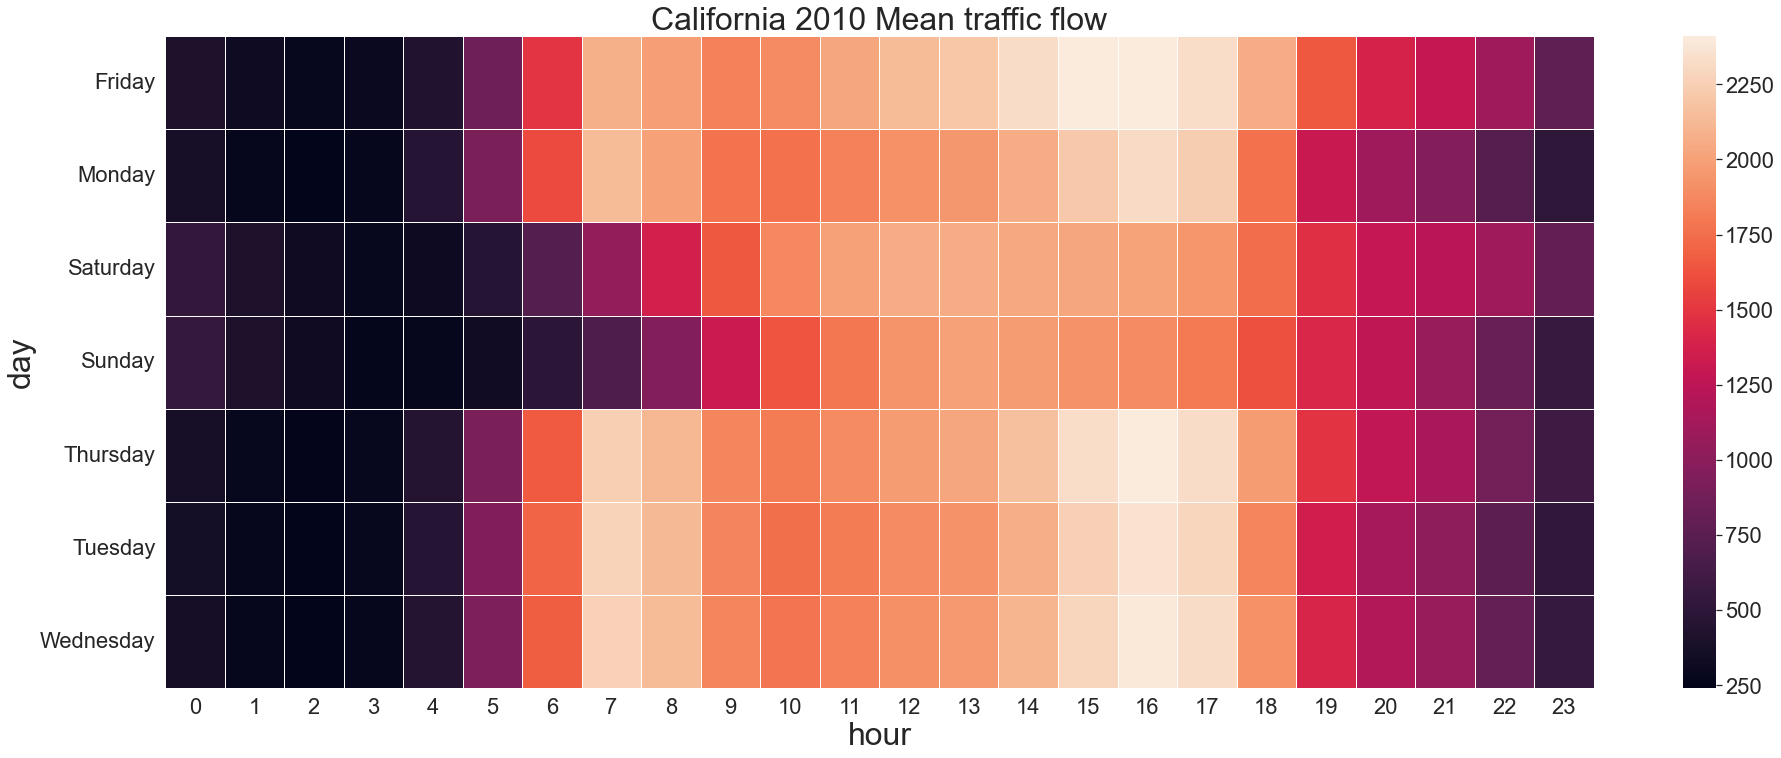

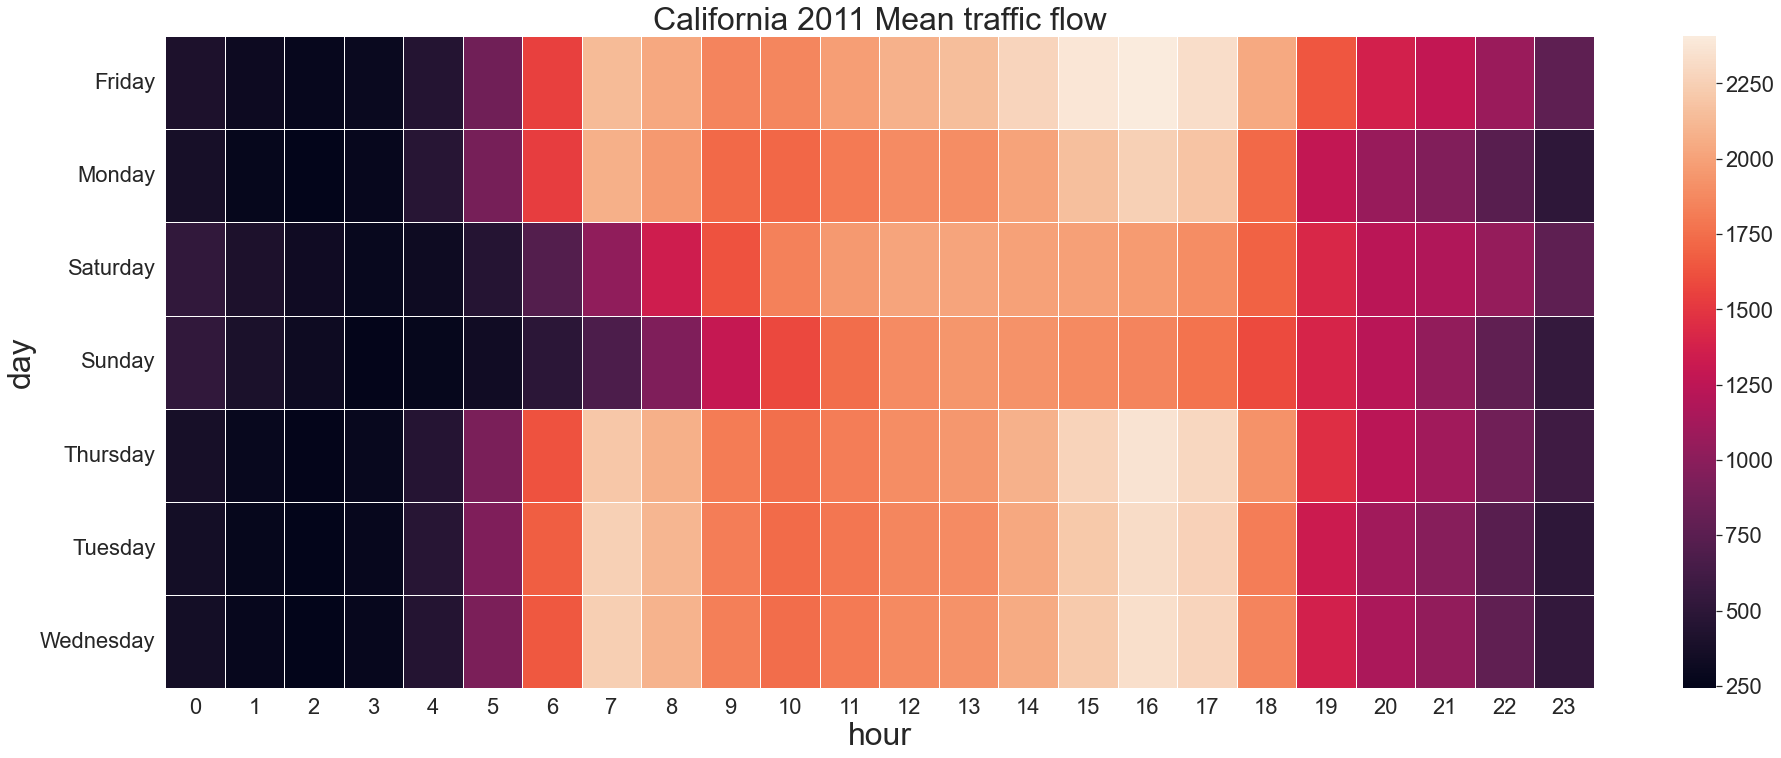

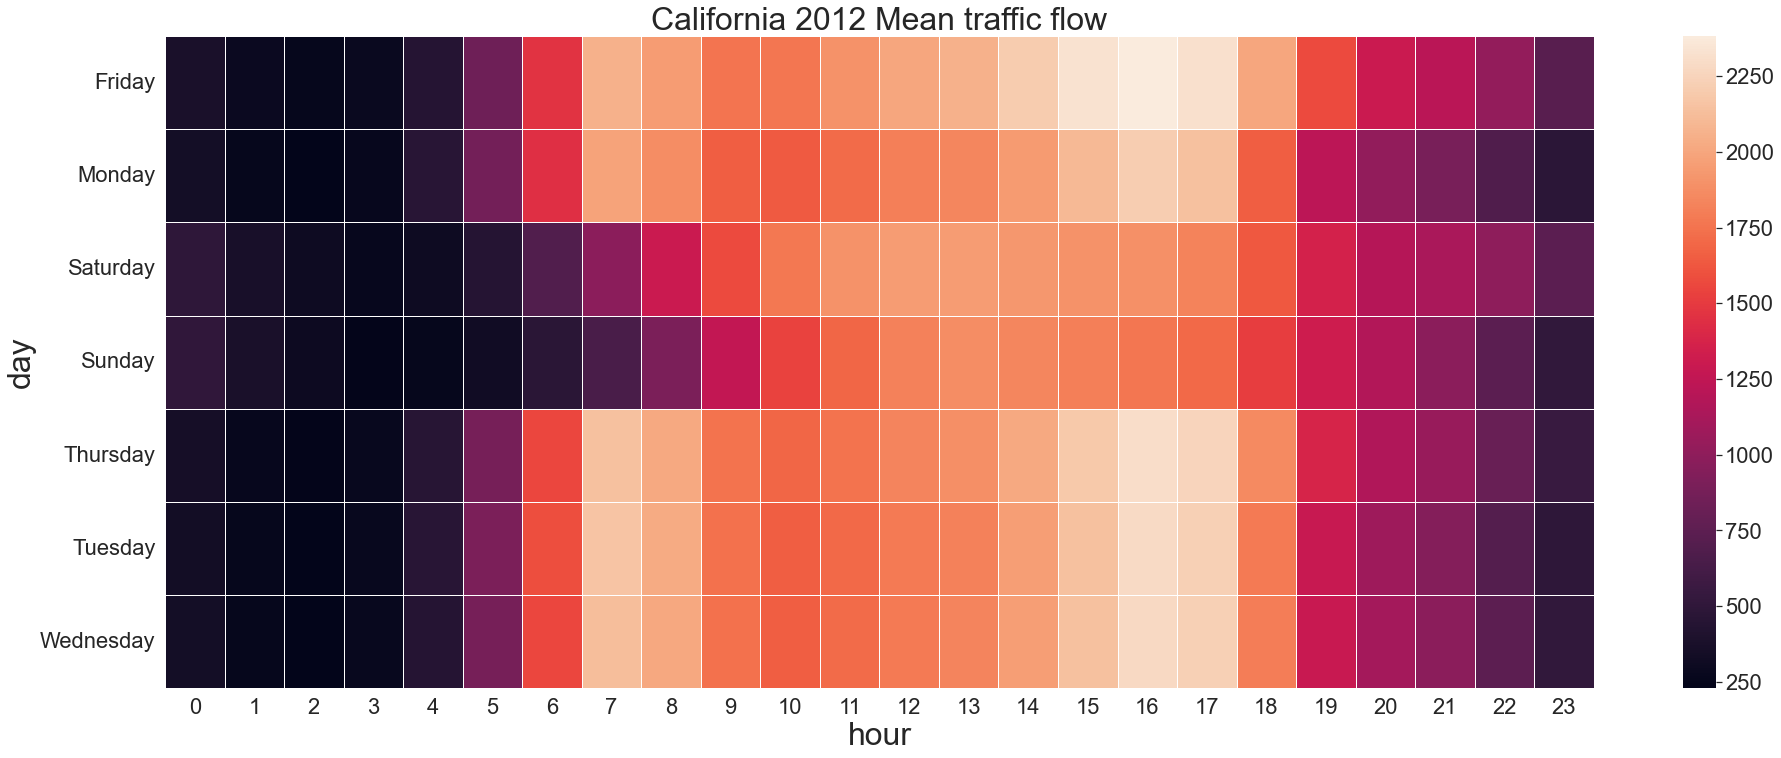

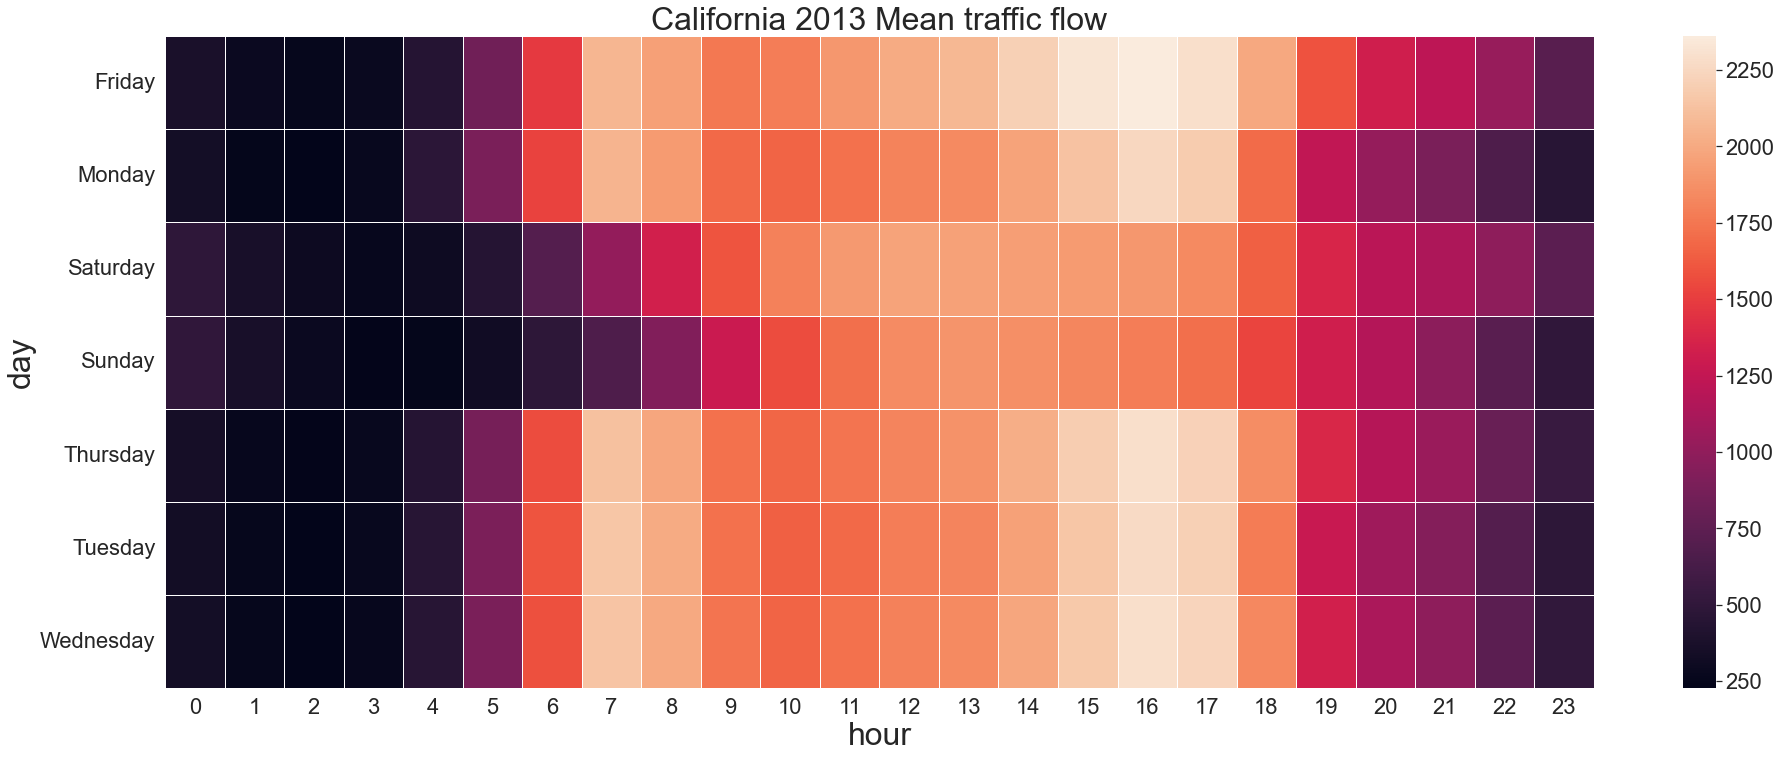

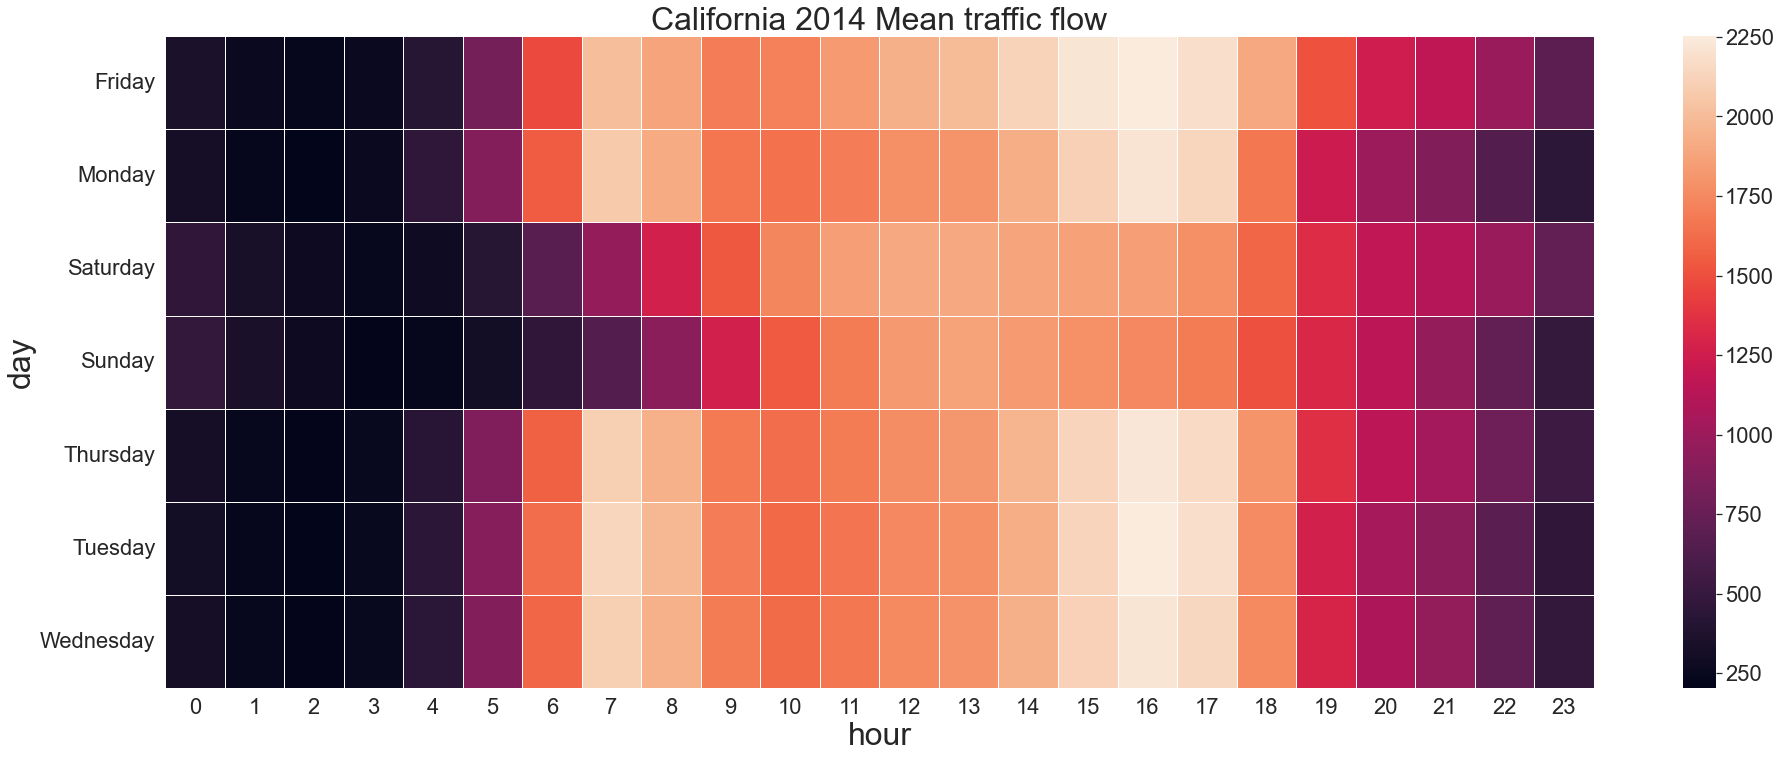

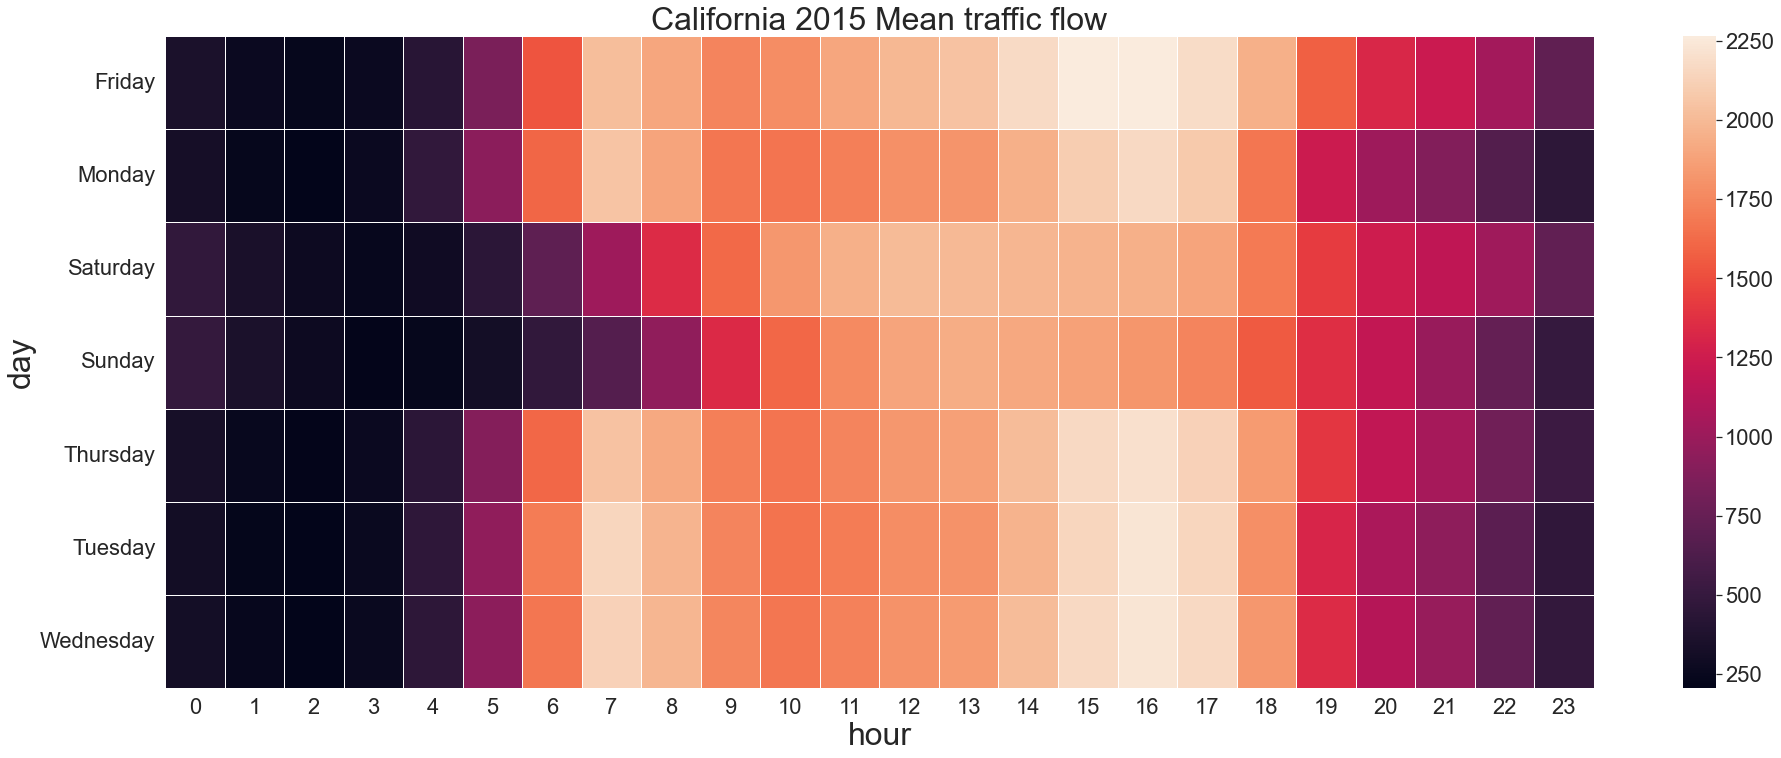

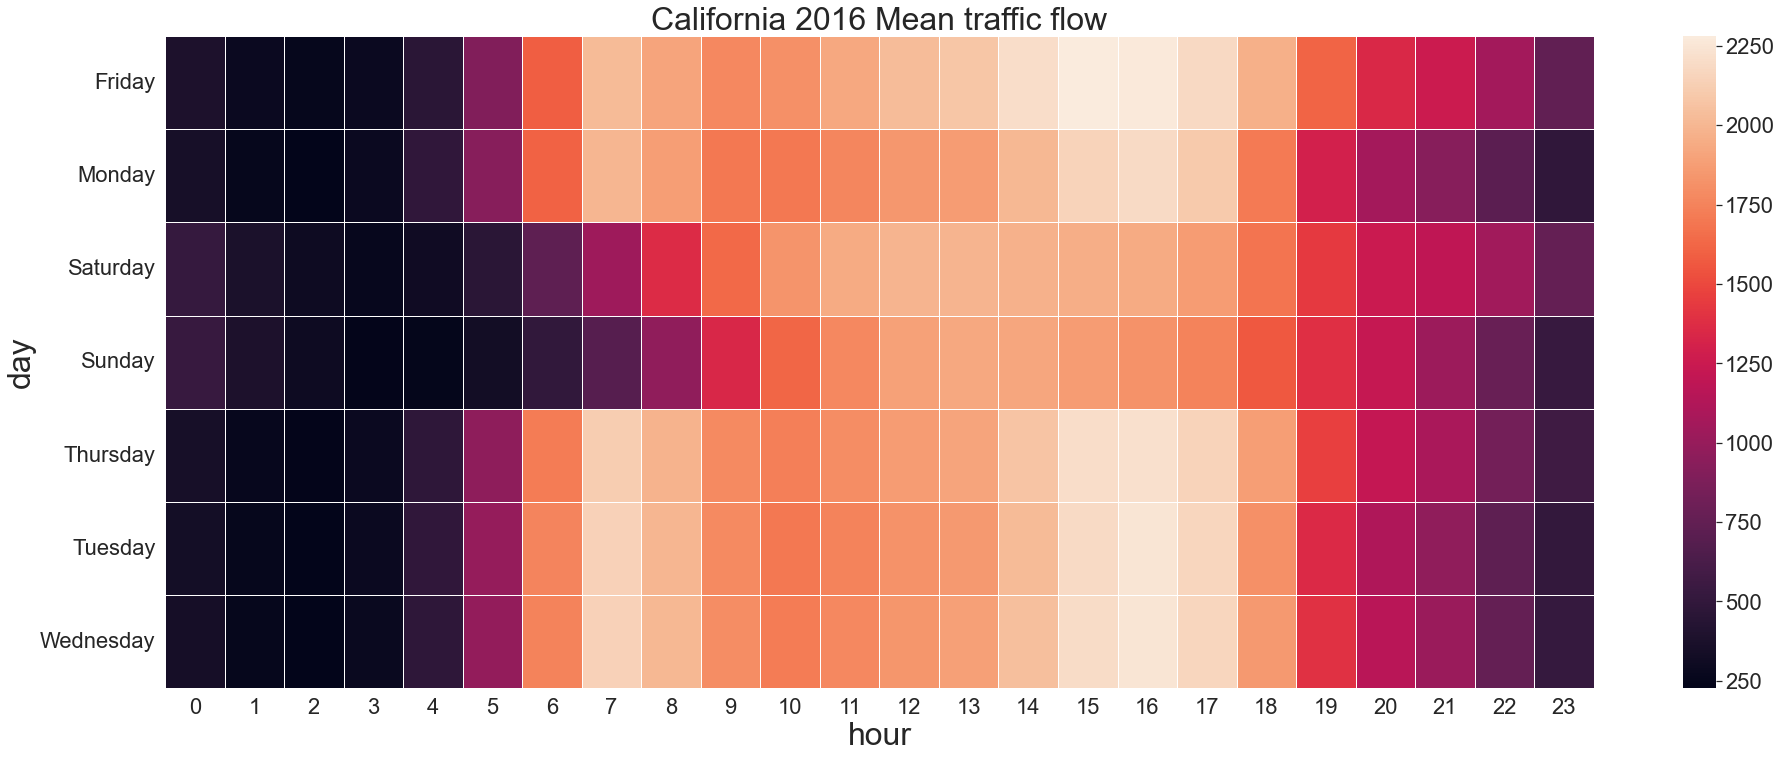

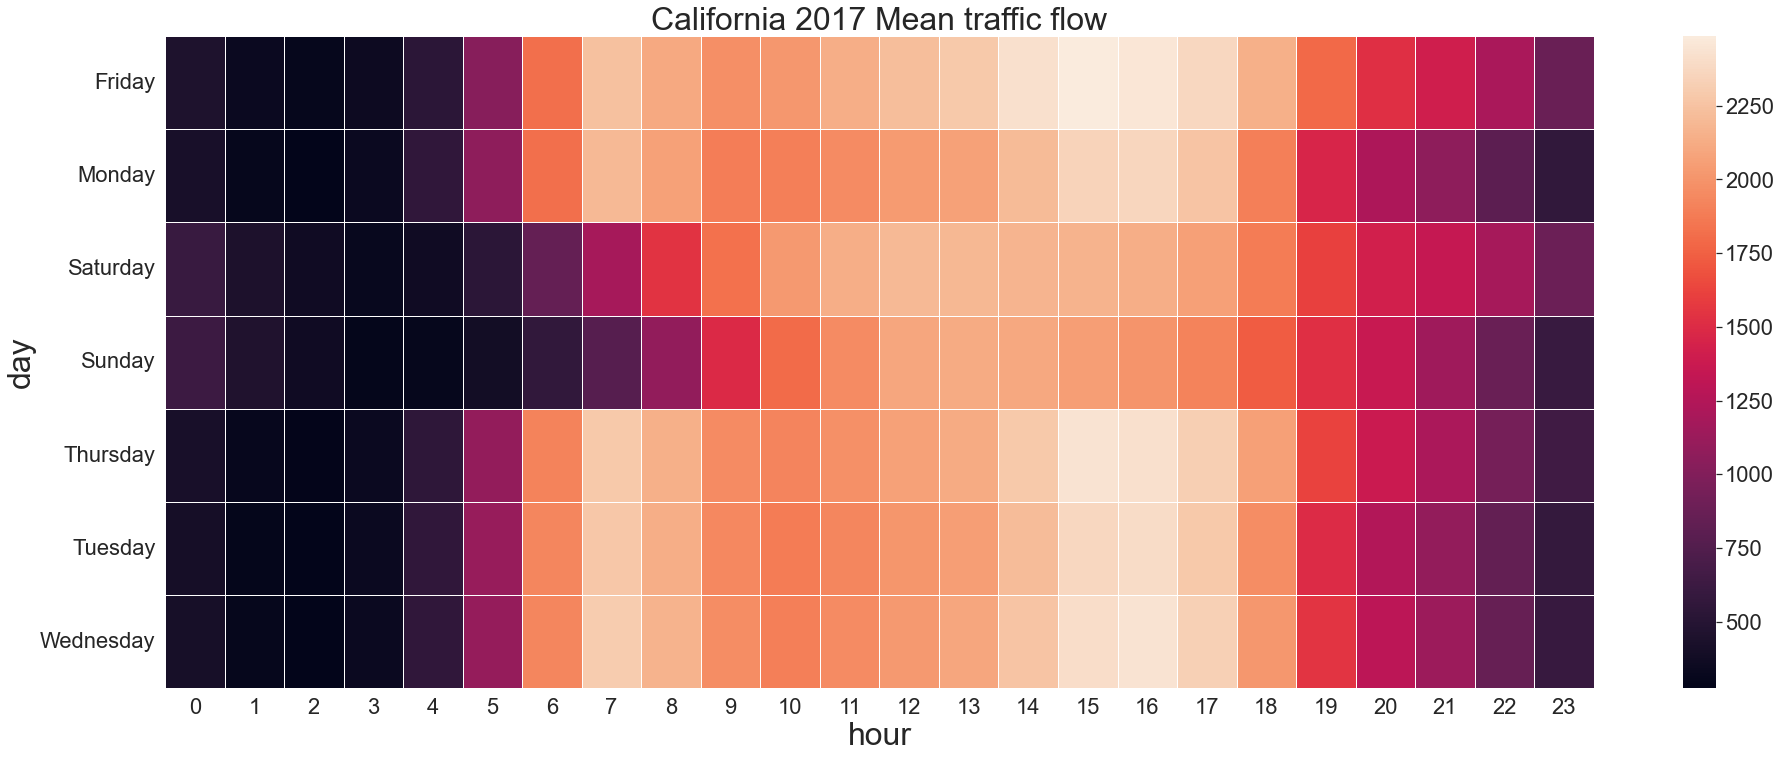

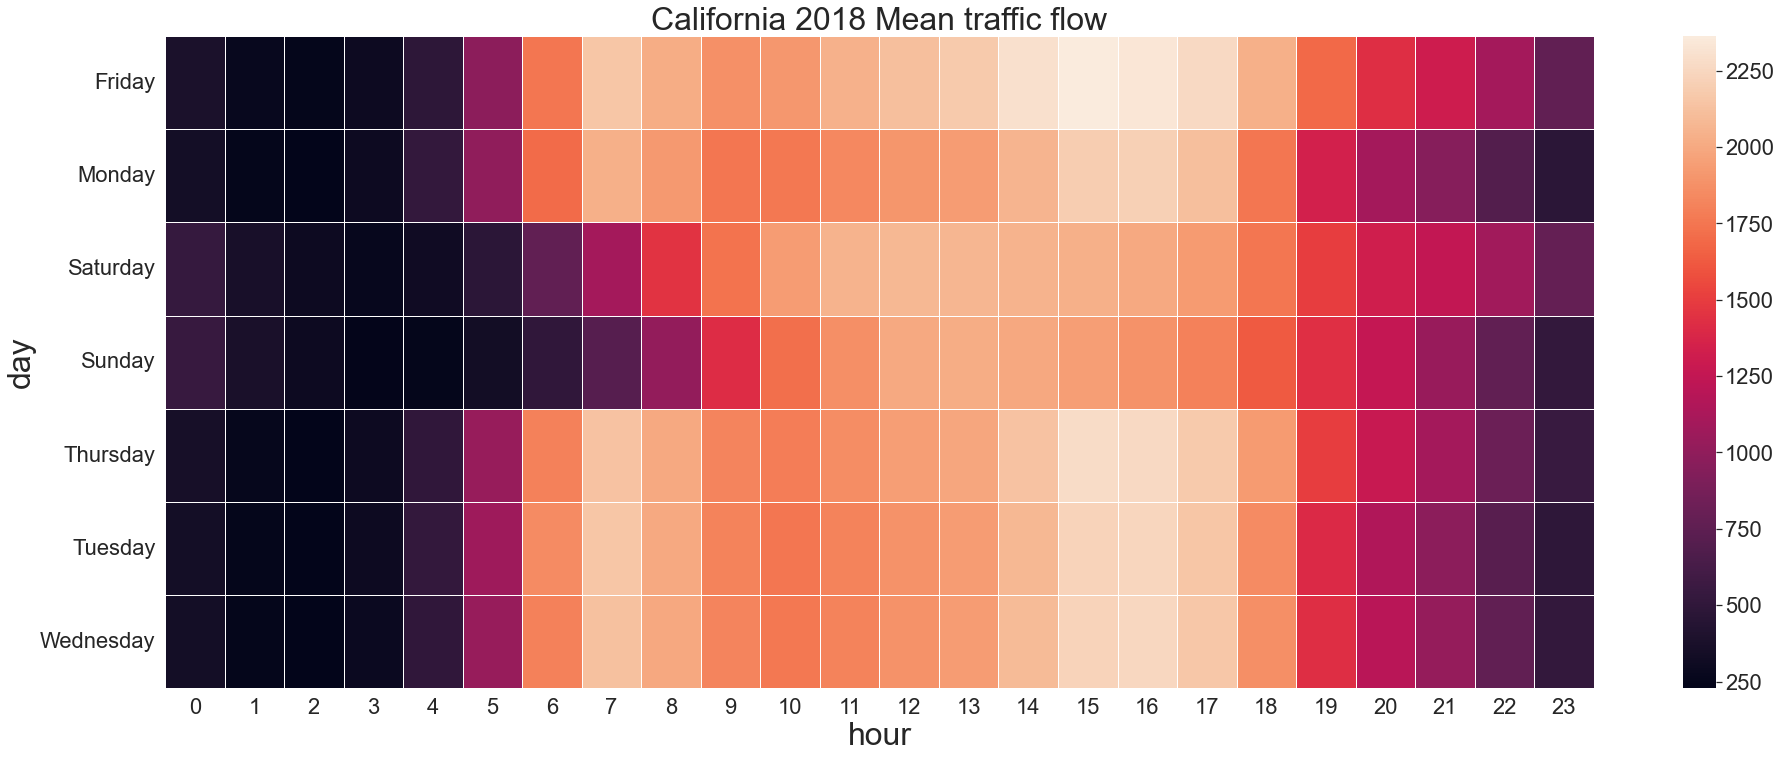

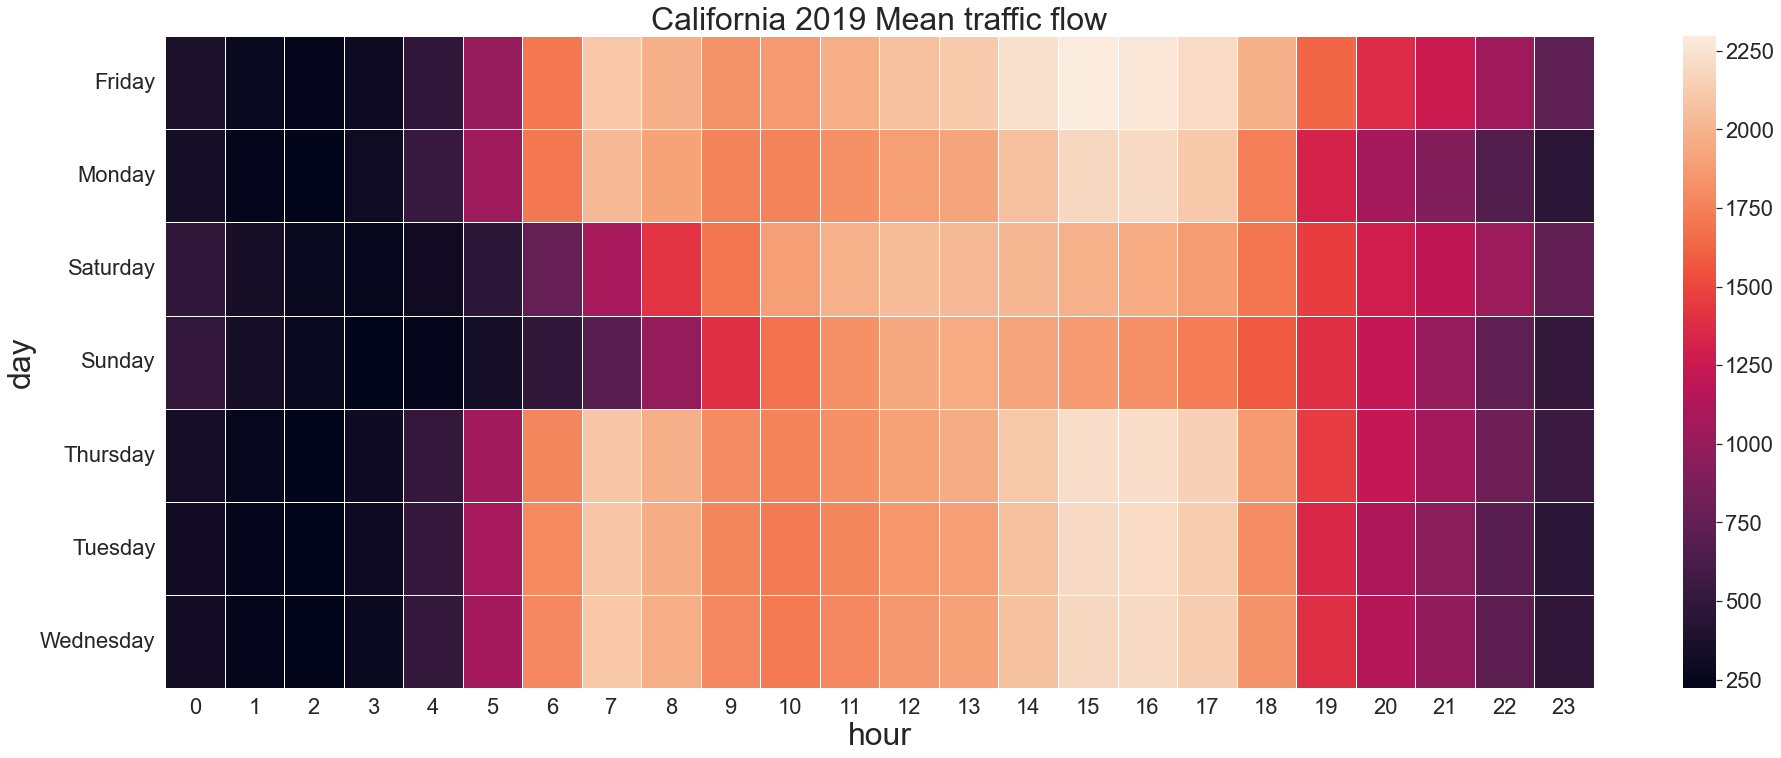

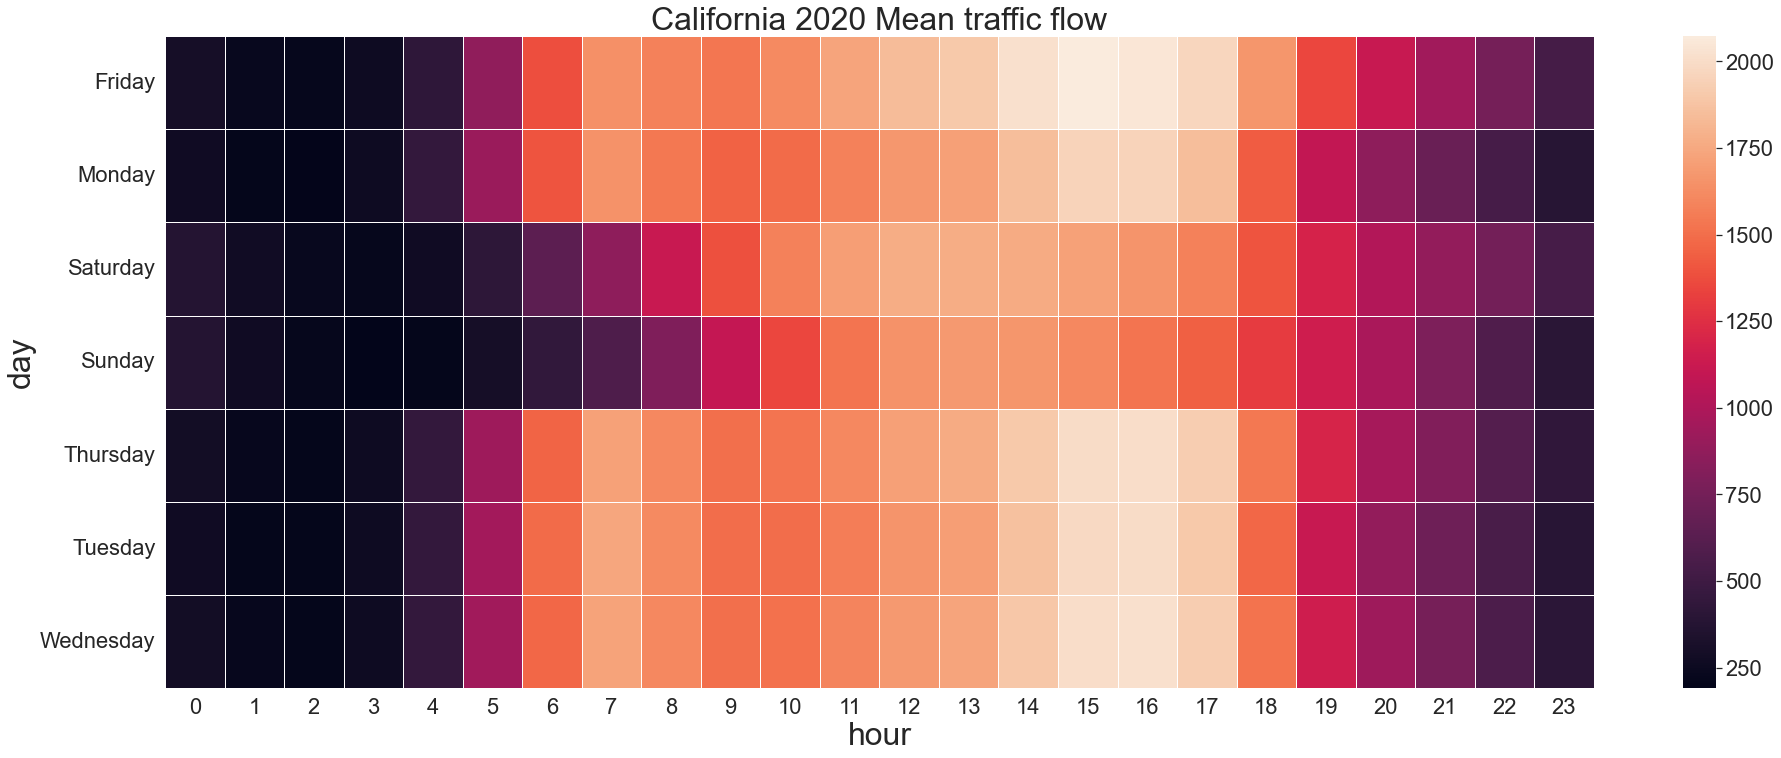

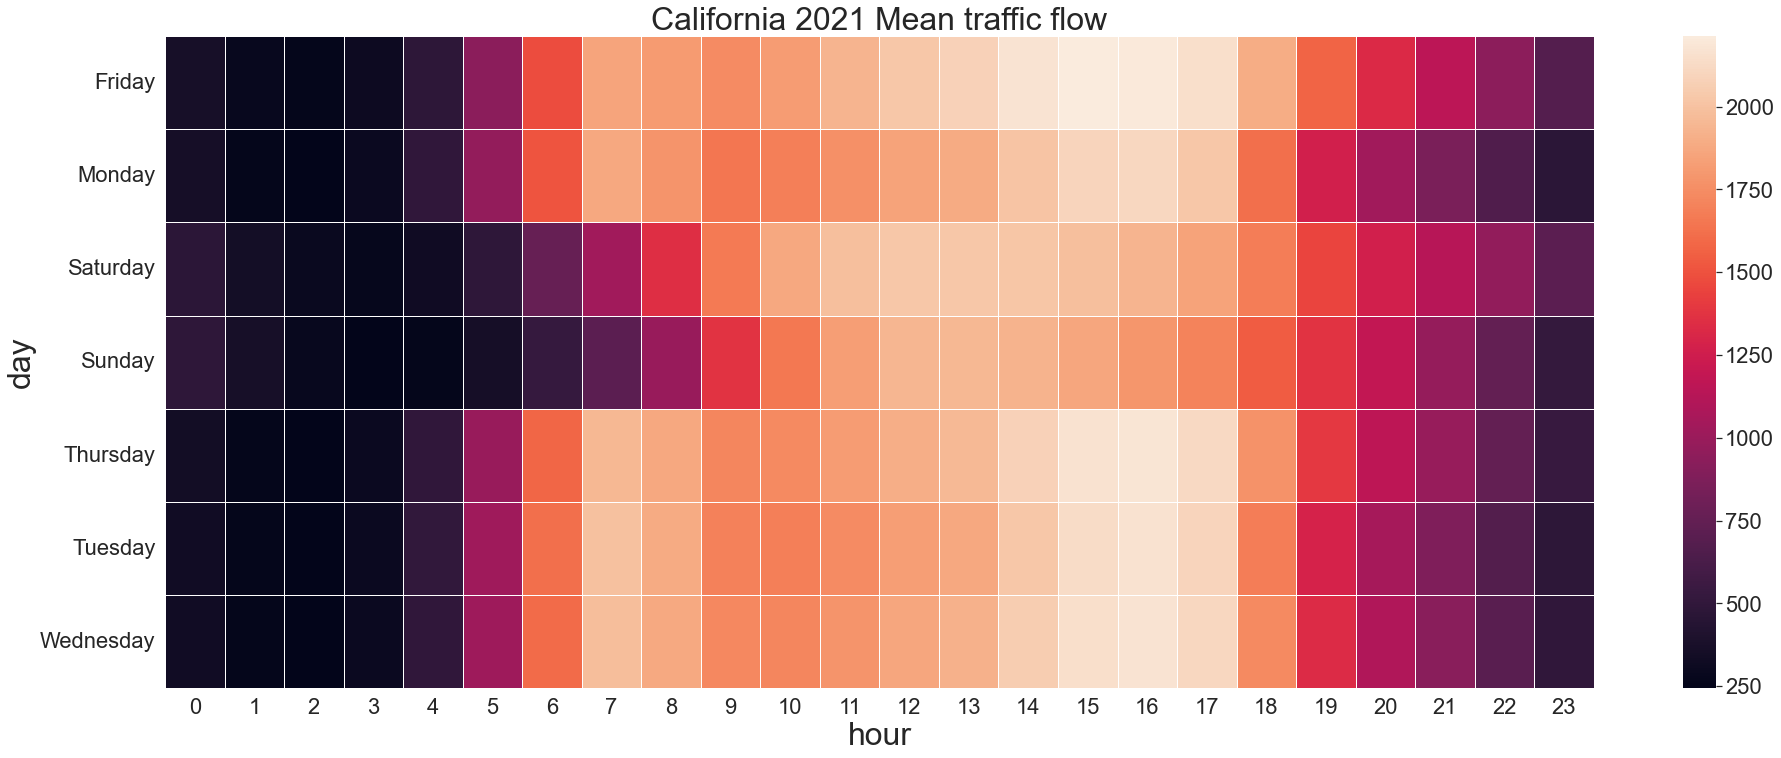

In [21]:
for year in range(2010, 2022):
    tmp = get_columns_per_year(pre_files, columns=['hour', 'day', 'total_flow'], year=year)
    tmp = tmp.groupby(['day', 'hour']).agg(['mean'])
    tmp.columns = tmp.columns.droplevel(0)
    tmp.reset_index(inplace=True)
    heatmap_data = pd.pivot_table(tmp, values='mean', 
                          index=['day'], columns='hour', ).reindex(index = days)
    fig, ax = plt.subplots(figsize=(32,12))
    sns.heatmap(heatmap_data, ax = ax,linewidth=.5)
    plt.xlabel("hour", size = 32)
    plt.ylabel("day", size = 32)
    plt.title(f"California {year} Mean traffic flow", size=32)

We can see that the average traffic flow doesn't change even though some events could have changed it like the lockdown during the pandemic. We could see in some precise month if this has impacted the traffic. 

In [34]:
df = get_columns_per_year(pre_files, columns=columns+['day', 'hour', 'month'], year=2020)
import json
with open('types.json', 'r') as f:
    data_types = json.load(f)
df = df.astype(data_types)

Let's take a look at the average delay_35, we wil try to find some values that can't be explained with our informations.

<AxesSubplot:title={'center':'delay_35 by day'}, xlabel='day'>

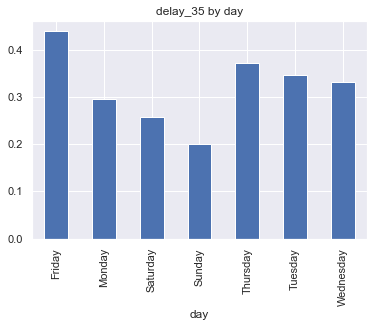

In [36]:
df.groupby('day')['delay_35'].mean().plot.bar(title='delay_35 by day')

We could see some correlations between the traffic flow and the delay.

<AxesSubplot:title={'center':'delay_35 by hour'}, xlabel='hour'>

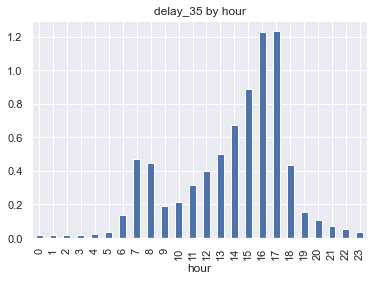

In [37]:
df.groupby('hour')['delay_35'].mean().plot.bar(title='delay_35 by hour')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'total_flow by delay_35'}, xlabel='total_flow', ylabel='delay_35'>

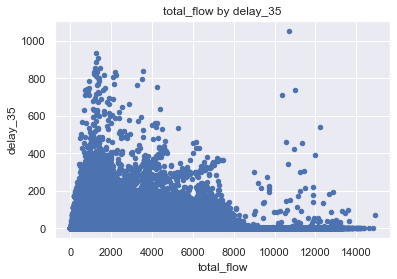

In [38]:
df.plot.scatter(x='total_flow', y='delay_35', title='total_flow by delay_35')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'delay 35 by delay 40'}, xlabel='delay_40', ylabel='delay_35'>

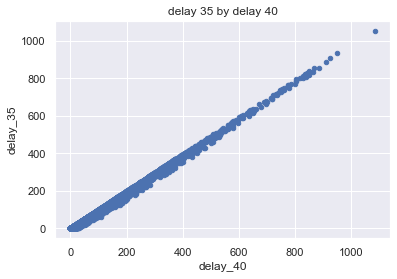

In [39]:
df.plot.scatter(x='delay_40', y='delay_35', title='delay 35 by delay 40')

We can see the linear relation between each delay.

Now let's take a look at the location of our stations.

In [40]:
import folium
station_metadata = pd.read_csv("d03_meta.txt", sep='\t')
station_metadata.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,308511,50,E,3,17,NaN,31.627,60.162,38.761062,-120.569835,3.134,ML,2,Sly Park Rd,1,NaN,NaN,NaN
1,308512,50,W,3,17,NaN,31.627,60.166,38.761182,-120.569866,3.995,ML,2,Sly Park Rd,1,NaN,NaN,NaN
2,311832,5,S,3,67,NaN,10.896,506.189,38.409782,-121.484120,NaN,FR,1,Elk Grove Blvd,1,NaN,NaN,NaN
3,311844,5,N,3,67,NaN,11.105,506.398,38.412779,-121.484363,NaN,OR,3,Elk Grove Blvd 5NB Slip,1,NaN,NaN,NaN
4,311847,5,N,3,67,NaN,12.185,507.478,38.428258,-121.487578,NaN,OR,3,Laguna Blvd to 5NB Slip,1,NaN,NaN,NaN


In [41]:
sacramento_coord = (38.575764, -121.478851)
coords = station_metadata[["Latitude", "Longitude"]].dropna().to_numpy()
m = folium.Map(location=sacramento_coord, tiles="Stamen Toner")
for coord in coords:
    folium.Marker(location=coord, icon=folium.Icon()).add_to(m)
m

## Analyze of the year 2020

Here, we will try to analyze the year 2020 more precisely and try to predict the traffic flow from our datas.

### Data analyze

In [5]:
df = get_columns_per_year(pre_files, columns=columns+['day', 'hour', 'month'], year=2020)
import json
with open('types.json', 'r') as f:
    data_types = json.load(f)
df = df.astype(data_types)

In [34]:
traf_flow_miss = np.sum(df.total_flow.isna())/len(df.total_flow)*100
print( f"Number of missing data of traffic flow: {traf_flow_miss:.3}%") 

Number of missing data of traffic flow: 7.54%


We have 7.54% of missing data. However, by looking at some columns, we can see there is a lot of NaN values. Let's check that.

In [55]:
print('\t the missingness of each value')
miss_col = []
for col in df.columns:
    col_miss = np.sum(df[col].isna()) / len(df[col]) * 100
    if col_miss > 0.1:
        miss_col.append(col)
    print("Number of missing data of {}:\t{:.3}%".format(col, col_miss)) 

	 the missingness of each value
Number of missing data of timestamp:	0.0%
Number of missing data of station:	0.0%
Number of missing data of district:	0.0%
Number of missing data of route:	0.0%
Number of missing data of direction:	0.0%
Number of missing data of lane_type:	0.0%
Number of missing data of station_lenght:	36.8%
Number of missing data of samples:	0.0%
Number of missing data of %_observed:	0.0%
Number of missing data of total_flow:	7.54%
Number of missing data of avg_occupancy:	35.8%
Number of missing data of avg_speed:	36.8%
Number of missing data of delay_35:	36.8%
Number of missing data of delay_40:	36.8%
Number of missing data of delay_45:	36.8%
Number of missing data of delay_50:	36.8%
Number of missing data of delay_55:	36.8%
Number of missing data of delay_60:	36.8%
Number of missing data of lane_n_flow:	11.3%
Number of missing data of lane_n_avg_occ:	37.3%
Number of missing data of lane_n_avg_speed:	38.1%
Number of missing data of day:	0.0%
Number of missing data of h

In [56]:
print(miss_col)

['station_lenght', 'total_flow', 'avg_occupancy', 'avg_speed', 'delay_35', 'delay_40', 'delay_45', 'delay_50', 'delay_55', 'delay_60', 'lane_n_flow', 'lane_n_avg_occ', 'lane_n_avg_speed']


### A first basic model

I tried a model with only the parameters that weren't missing at all. However, I had two problems. The first one being with only theses parameters, i didnt have enaught accuracy. I only had a r2 of 0.4. And Secondly, the data being huge, i couldnt create a big X_test so i decided to reduce the number of samples and increasing the number of parameters. So we will use the dataFrame df_avg which is the one without any missing data. However, before dropping our lines, we will check if our variables are missing completely at random, missing at random or not missing at random. The ones missing at random or completly at random will be cut from the database and the ones not missing at random will be studied. 

In [44]:
df_mod = df.drop(["district", "timestamp"], axis=1)

#### A visual approach

We will first plot our missing value to check if we can see any pattern from here.

In [45]:
missing_val = df_mod.isna()
missing_val.head()

,station,route,direction,lane_type,station_lenght,samples,%_observed,total_flow,avg_occupancy,avg_speed,...,delay_45,delay_50,delay_55,delay_60,lane_n_flow,lane_n_avg_occ,lane_n_avg_speed,day,hour,month
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,True,True,...,True,True,True,True,False,True,True,False,False,False
3,False,False,False,False,True,False,False,False,True,True,...,True,True,True,True,False,True,True,False,False,False
4,False,False,False,False,True,False,False,False,True,True,...,True,True,True,True,False,True,True,False,False,False


In [46]:
samples = missing_val[:10000]

[Text(0.5, 1.0, 'missingness by value')]

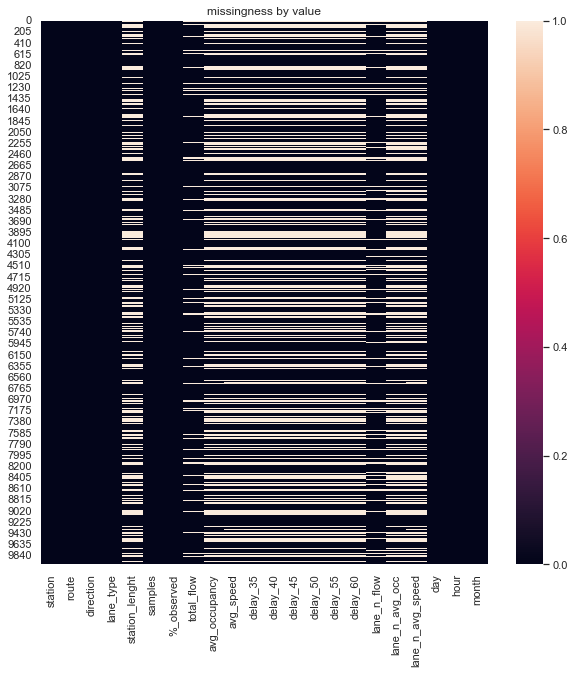

In [51]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(samples, ax=ax).set(title='missingness by value')

We cann see a pattern here. Indeed, if the station lenght is missing we can see that the others value are missing too. Therefore, we will check the missingness of the station lenght only.

In [62]:
miss_vals = []
for col in miss_col:
    miss_val = np.sum(df[col].isna()) / np.sum(df['lane_n_avg_speed'].isna())
    print('{} of missing value of {} if lane_n_avg_speed is missing'.format(miss_val, col))
    miss_vals.append(miss_val)

0.9659841623200212 of missing value of station_lenght if lane_n_avg_speed is missing
0.19787913008464966 of missing value of total_flow if lane_n_avg_speed is missing
0.9383320914346013 of missing value of avg_occupancy if lane_n_avg_speed is missing
0.9659850879588275 of missing value of avg_speed if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_35 if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_40 if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_45 if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_50 if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_55 if lane_n_avg_speed is missing
0.9659841623200212 of missing value of delay_60 if lane_n_avg_speed is missing
0.2954967672064684 of missing value of lane_n_flow if lane_n_avg_speed is missing
0.9788736827002735 of missing value of lane_n_avg_occ if lane_n_avg_speed is missing
1.0 of missing value of lane

<BarContainer object of 13 artists>

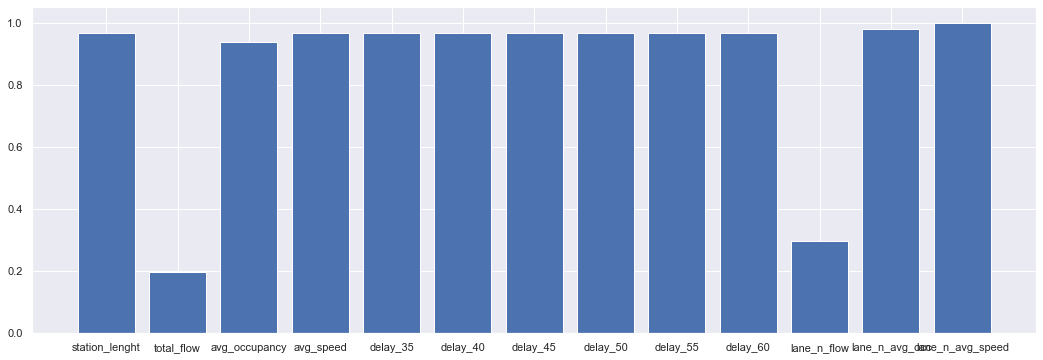

In [76]:
plt.figure(figsize=(18,6))
plt.bar(x=miss_col, height=miss_vals)

Here, we check the mean value of the missingness of station_leght for each sation.


In [114]:
def check_missingness_with_param(miss_val, related_val, df):
    contigency = df_mod[["station", "station_lenght"]].copy()
    contigency["station_lenght"] = contigency.station_lenght.isna()
    cm = contigency.groupby("station")["station_lenght"].mean()
    print("values that aren't 0 or 1 for {}: \n{}".format(miss_val, cm[(cm > 0) & (cm < 1)]))
    return cm[(cm > 0) & (cm < 1)].shape[0] / cm.shape[0]

In [115]:
sl_miss_by_sat = check_missingness_with_param('station_lenght', 'station', df)
lnf_miss_by_sat = check_missingness_with_param('lane_n_flow', 'station', df)

print("\nrelation of station and missing value: \n \
      station_leght:\t{} \n\tlane_n_flow:\t{}".format(sl_miss_by_sat, 
                                                    lnf_miss_by_sat))

values that aren't 0 or 1 for station_lenght: 
station
318993     0.611978
3044012    0.432442
Name: station_lenght, dtype: float64
values that aren't 0 or 1 for lane_n_flow: 
station
318993     0.611978
3044012    0.432442
Name: station_lenght, dtype: float64

relation of station and missing value: 
       station_leght:	0.0014378145219266715 
	lane_n_flow:	0.0014378145219266715


It seems that the missingness of our data is related to the station. So our datas is missing at random.

Let's check the values of delay.

In [49]:
delays_col = ["delay_35", "delay_40", "delay_45", "delay_50", "delay_55", "delay_60"]

delays = df_mod[delays_col].dropna().copy().astype('int16')
delays

,delay_35,delay_40,delay_45,delay_50,delay_55,delay_60
0,0,0,0,0,0,0
1,0,0,0,0,0,0
7,0,0,0,0,0,0
10,0,0,0,0,0,0
12,0,0,0,0,0,0
...,...,...,...,...,...,...
964961,0,0,0,0,0,0
964964,0,0,0,0,0,0
964965,0,0,0,0,0,0
964966,0,0,0,0,0,0


In [50]:
np.sum(delays != 0, axis=1) != 0

0         False
1         False
7         False
10        False
12        False
          ...  
964961    False
964964    False
964965    False
964966    False
964967    False
Length: 7164860, dtype: bool

In [132]:
delays[delays != 0].dropna()

,delay_35,delay_40,delay_45,delay_50,delay_55,delay_60
429,4.0,5.0,5.0,6.0,6.0,7.0
763,1.0,4.0,6.0,8.0,10.0,11.0
764,1.0,3.0,6.0,7.0,9.0,10.0
1976,6.0,11.0,14.0,17.0,19.0,21.0
1977,3.0,6.0,9.0,11.0,13.0,14.0
...,...,...,...,...,...,...
961154,3.0,3.0,3.0,4.0,4.0,4.0
961788,1.0,3.0,5.0,7.0,8.0,9.0
962451,6.0,6.0,7.0,7.0,7.0,7.0
963085,1.0,3.0,4.0,5.0,6.0,7.0


To get more accurate value, we will only take stations with the measure of the delay and the station lenght.

#### First model analysis

We will first create a model to predict the average speed in our dataset.

In [6]:
df = df.dropna().drop(["timestamp", "district"], axis=1)

In [7]:
num_col = ['station_lenght', 'samples', '%_observed', 
           'total_flow', 'avg_occupancy', 'avg_speed', 
           'delay_35',
           'lane_n_flow', 'lane_n_avg_occ', 'lane_n_avg_speed']
cat_col = ['day', 'month', 'hour', 'route']
           #'station', 'direction', 'lane_type']

predicted_value = 'total_flow'

X_num = df[num_col].drop(predicted_value, axis=1)
X_cat = pd.get_dummies(df[cat_col].astype(str))

y = df[predicted_value].to_numpy()
y = np.array(y.astype('int32'))

In [8]:
X_cat

,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_April,month_August,month_December,...,route_267,route_28,route_5,route_50,route_51,route_65,route_70,route_80,route_89,route_99
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964961,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
964964,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
964965,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
964966,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


There mighe be some values that are strongly correlated to our predicted_value, so if they have a linear correlation, we will remove them. Indeed, this will mean that this input isn't an important feature to add.

In [9]:
corr = (df[num_col].corr()[predicted_value] > 0.7).drop(labels=[predicted_value])
X_num = X_num[X_num.columns[~corr]]

Text(0.5, 1.0, 'correlation between values')

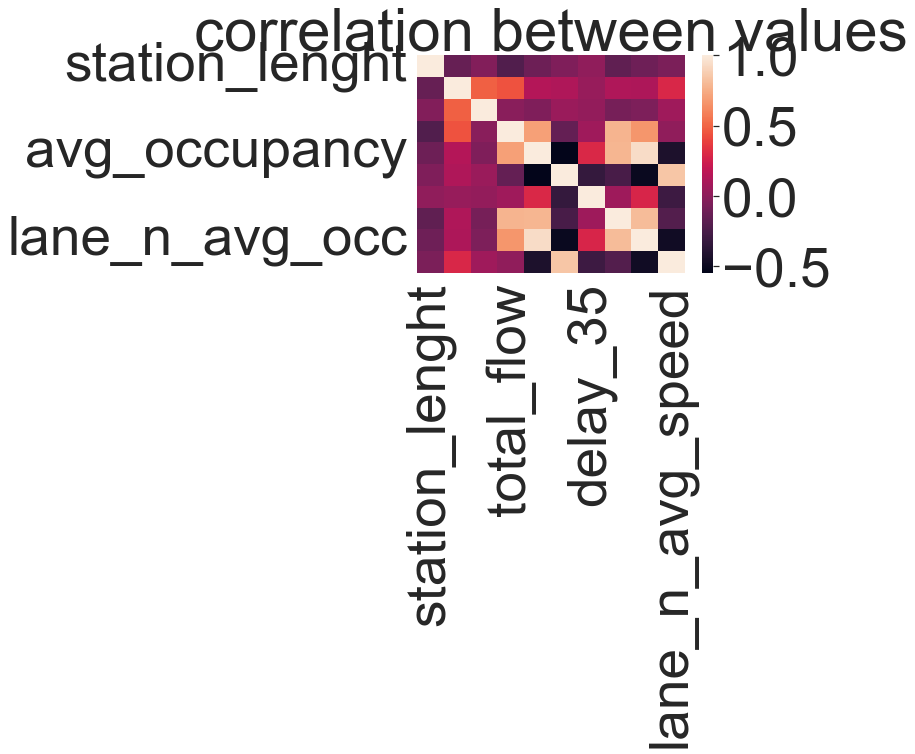

In [10]:
sns.heatmap(df[num_col].corr())
plt.title("correlation between values")

In [11]:
X_n_c = pd.concat([X_num, X_cat], axis='columns')
X_n_c

,station_lenght,samples,%_observed,avg_speed,delay_35,lane_n_avg_occ,lane_n_avg_speed,day_Friday,day_Monday,day_Saturday,...,route_267,route_28,route_5,route_50,route_51,route_65,route_70,route_80,route_89,route_99
0,5.000000,238,100,66.6875,0.0,0.000300,71.3125,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3.994141,217,0,63.8125,0.0,0.024307,66.3125,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0.280029,354,100,65.8750,0.0,0.003700,71.6875,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,1.348633,595,100,68.6250,0.0,0.005699,76.3125,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,2.160156,0,0,65.8125,0.0,0.036804,71.8750,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964961,1.602539,360,100,67.8750,0.0,0.007599,71.8750,0,0,0,...,0,0,0,0,0,1,0,0,0,0
964964,4.226562,120,100,65.0000,0.0,0.003500,65.0000,0,0,0,...,0,0,0,1,0,0,0,0,0,0
964965,0.551758,478,100,70.3125,0.0,0.012604,75.0000,0,0,0,...,0,0,0,1,0,0,0,0,0,0
964966,5.000000,240,100,67.6875,0.0,0.002800,71.1875,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
y

array([ 16, 532, 935, ..., 874,  94,  75])

#### The impact of data preprocessing

In this section we will try to predict the selected value with different type of data.

To handle the type of model we will use this letters:
* r for raw
* p for processed
* n for numerical
* c for categorical
* m for model

In [13]:
sns.set(font_scale=1)

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression

do_nothing = FunctionTransformer(lambda w: w) 

def create_pipe(model, num_encoder):
    pipe = Pipeline([
        ('num', num_encoder) ,
        ('model', model)
    ])
    return pipe

We will use the cross validation score to be sure that our results aren't due to randomness.

In [14]:
def train_test_model(model, X, y):
    kf = KFold(n_splits=5)
    scores = []
    for train, test in tqdm(kf.split(X, y)):
        model.fit(X.iloc[train, :], y[train])
        scores.append(model.score(X.iloc[test, :], y[test]))
    return np.mean(scores)

In [16]:
rnm = 'rnm', (LinearRegression(), do_nothing)
pnm = 'pnm', (LinearRegression(), Normalizer())

models = [rnm, pnm]

pipes = {name: create_pipe(*model) for name, model in models}


In [17]:
scores = {name: train_test_model(pipe, X_num, y) for name, pipe in pipes.items()}
print("score without categorical val: ", scores)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

score without categorical val:  {'rnm': 0.6542719062850259, 'pnm': 0.4343188342214829}


In [18]:
scores = {name: train_test_model(pipe, X_n_c, y) for name, pipe in pipes.items()}
print("score without categorical val: ", scores)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

score without categorical val:  {'rnm': 0.5088309358101704, 'pnm': 0.26432872215753195}


In [19]:
pipe = create_pipe(*rnm[1])
X_train, X_test, y_train, y_test = train_test_split(X_n_c,y)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7260089822652422

It looks like using a normalizer doesn't increase the accuracy of our model. This means that some of our numerical value are either useless or less important than others. However, adding categorical data increase the accuracy. Moreover, it seems that we don't have enaugh data to use KFold. This might be caused by data imbalance.

In [25]:
def eval_fun(model, Sn):
    X_train, X_test, y_train, y_test = train_test_split(X_n_c[Sn],y)
    pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

In [30]:
def BS(F, data, predicted_value, Eval, lim):
    """
    Beam Search
    :param lim: size of the memory, integer
    """
    Mem = [(0, set())] # (Score, Feature set)
    S_best, sc_best = set(), 0 # Keep in memory the best state
    y = data[predicted_value]/data[predicted_value].max()
    cc = set(cat_col)
    nc = set(num_col)
    print(cc, nc)
    while len(Mem) > 0:
        sc, S = Mem.pop(0) # Take the best set in the memory
        if sc > sc_best: # Update the best set seen so far
            S_best, sc_best = S, sc
        S_new = [S | {c} for c in F - S] # Add one unseen feature
        M_new = [(Eval(
            create_pipe(LinearRegression(), do_nothing), Sn), Sn)
                for Sn in S_new] # Score each set
        Mem = sorted(Mem + M_new, reverse=True)[:lim] # Update the memory
    return S_best, sc_best

In [ ]:
S, sc = BS(set(X_n_c.columns), df, predicted_value, eval_fun, 5)

{'hour', 'day', 'route', 'month'} {'avg_occupancy', 'lane_n_flow', 'delay_35', 'avg_speed', 'lane_n_avg_speed', 'samples', '%_observed', 'lane_n_avg_occ', 'total_flow', 'station_lenght'}


In [ ]:
S, sc

We can see that normalizing our input data seems to make our predictions worse. It could be explained by the fact that somes inputs. Moreover, by using the beam search, we can see the most likely best inputs.

In [ ]:
S = {'%_observed',
  'avg_speed',
  'day',
  'delay_35',
  'hour',
  'lane_n_avg_occ',
  'lane_n_avg_speed',
  'month',
  'route',
  'samples',
  'station_lenght'} # we put S here in order to not have to execute the cell above again

X = df[S]
S_cat_col = list(S & set(cat_col))
S_num_col = list(S & set(num_col))
best_model = create_model(LinearRegression(), do_nothing, 
                          S_num_col)
best_score = train_test_model(best_model, X, y)

In [ ]:
best_score[0]

Let's try to check a better model.

In [117]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

models = [('lr', LinearRegression()), ('lsvr', LinearSVR(verbose=2)), ('knn', KNeighborsRegressor()), ('sgd', SGDRegressor())] #57 is the dim expected

pipes = {name: create_model(model, do_nothing) for name, model in models}


The time to train each type seems too big to train properly. However, we could easily create a list of model to test them all and compare each result. However, we will just use one for SGDRegressor

In [118]:
score, X_test, y_test = train_test_model(pipes['lr'], X, y)

In [120]:
print(score)

0.3583859825339936


## Accident Analysis

Let's analyze the data of the accident to see if it can improve our model.

In [55]:
df_inc = pd.read_csv("all_text_chp_incident_day_2020_01_01.txt", header=None, parse_dates=[3])
columns_inc = ["incident_ID", "CC_code", "Incident_number",
               "timestamp", "description", "location", 
               "area", "zoom_map", "TB_xy", "lat", "long",
              "district", "county_fips_id", "city_fips_id", 
               "freeway_num", "freeway_dir", "state_postmile", "abs_postmile",
              "severity", "duration"]
df_inc.columns = columns_inc
df_inc["day"] = df_inc.timestamp.dt.day_name()
df_inc["hour"] = pd.DatetimeIndex(df_inc.timestamp).hour
df_inc["month"] = df_inc.timestamp.dt.month_name()
df_inc["year"] = pd.DatetimeIndex(df_inc.timestamp).year
df_inc['acc'] = 1

(847, 25)

Let's see the type of descritpion we have.

In [57]:
df_inc.description.drop_duplicates()

0        1183-Trfc Collision-Unkn Inj
2                 FIRE-Report of Fire
3                 1125-Traffic Hazard
6                 1125A-Animal Hazard
8          1182-Trfc Collision-No Inj
10                     CFIRE-Car Fire
22      1179-Trfc Collision-1141 Enrt
24                WW-Wrong Way Driver
35       20001-Hit and Run w/Injuries
41      20002-Hit and Run No Injuries
86                          SIG Alert
99                  CLOSURE of a Road
143                           SPINOUT
147                            JUMPER
164      1179-Trfc Collision-1141Enrt
183                     1144-Fatality
218       DOT-Request CalTrans Notify
229        ANIMAL-Live or Dead Animal
233    1166-Defective Traffic Signals
265      1013-Road/Weather Conditions
353               BREAK-Traffic Break
504      23114-Object Flying From Veh
555      1184-Provide Traffic Control
642                     WIND Advisory
829             TADV-Traffic Advisory
Name: description, dtype: object

In [46]:
df_accident_veh = df_inc[df_inc.description.str.contains("Collision")]
df_accident_veh['acc'] = 1
df_accident_veh.head(5)

C:\Users\yassi\AppData\Local\Temp/ipykernel_14460/3956049160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accident_veh['acc'] = 1


,incident_ID,CC_code,Incident_number,timestamp,description,location,area,zoom_map,TB_xy,lat,...,freeway_dir,state_postmile,abs_postmile,severity,duration,day,hour,month,year,acc
0,19234768,SAHB,200101,2020-01-01 00:03:00,1183-Trfc Collision-Unkn Inj,W Sunset Blvd E Onr / Sr65 S,Auburn,NaN,NaN,38.811739,...,S,R9.18,68.914,NaN,8.0,Wednesday,0,January,2020,1
1,19234770,GGHB,200101,2020-01-01 00:01:00,1183-Trfc Collision-Unkn Inj,Us101 N / Westlake Blvd,Moorpark,NaN,NaN,34.160675,...,N,1.051,40.600,NaN,67.0,Wednesday,0,January,2020,1
8,19234790,GGHB,200101,2020-01-01 00:18:00,1182-Trfc Collision-No Inj,I80 W / Sfobb Toll Plaza Ofr,Oakland,NaN,NaN,37.825388,...,W,2.49,7.800,NaN,3.0,Wednesday,0,January,2020,1
11,19234795,LAHB,200101,2020-01-01 00:28:00,1183-Trfc Collision-Unkn Inj,I10 E / S Hoover St,Central LA,NaN,NaN,34.036997,...,E,14.255,12.100,NaN,1.0,Wednesday,0,January,2020,1
12,19234798,GGHB,200101,2020-01-01 00:32:00,1182-Trfc Collision-No Inj,Us101 S / So Del Norte Blvd,Ventura,NaN,NaN,34.221667,...,S,18.677,58.200,NaN,27.0,Wednesday,0,January,2020,1


<AxesSubplot:xlabel='hour'>

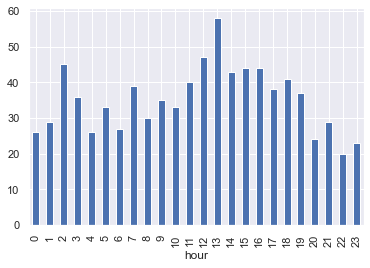

In [49]:
df_inc.groupby('hour')["acc"].sum().plot.bar()


In [19]:
df.head()

,timestamp,station,district,route,direction,lane_type,station_lenght,samples,%_observed,total_flow,...,delay_45,delay_50,delay_55,delay_60,lane_n_flow,lane_n_avg_occ,lane_n_avg_speed,day,hour,month
0,2020-01-01,308511,3,50,E,ML,5.000000,238,100,16.0,...,0.0,0.0,0.0,0.0,4.0,0.000300,71.3125,Wednesday,0,January
1,2020-01-01,308512,3,50,W,ML,3.994141,217,0,532.0,...,0.0,0.0,0.0,0.0,235.0,0.024307,66.3125,Wednesday,0,January
2,2020-01-01,311831,3,5,S,OR,NaN,119,100,29.0,...,NaN,NaN,NaN,NaN,29.0,NaN,NaN,Wednesday,0,January
3,2020-01-01,311832,3,5,S,FR,NaN,119,100,230.0,...,NaN,NaN,NaN,NaN,230.0,NaN,NaN,Wednesday,0,January
4,2020-01-01,311844,3,5,N,OR,NaN,237,100,220.0,...,NaN,NaN,NaN,NaN,104.0,NaN,NaN,Wednesday,0,January
